## Competição DSA - Kaggle - Fevereiro 2019

## Prevendo Energy Star Score

### Conseguindo segunda melhor posição no desafio

Desenvolvido por: Allyson de Lima Medeiros   
Data: 04-03-2019    
https://www.linkedin.com/in/allysonlm/    


## Problema

O conjunto de dados anexado a esta competição contém dados sobre a eficiência energética de edifícios. O dataset foi extraído do web site Open Data for All New Yorkers (https://opendata.cityofnewyork.us/). Alternativamente o dataset pode ser encontrado aqui: https://catalog.data.gov/dataset

Nossa hipótese é que esse conjunto de dados contém variáveis ​​independentes que podem ser usadas para inferir fatos interessantes sobre outros edifícios em Nova York. O principal interesse é a pontuação (score) de Energy Star, pois acreditamos que essa pontuação é usada como uma medida agregada do desempenho energético de um prédio. Nossa pergunta é simples:

Este conjunto de dados contém um conjunto de variáveis ​​independentes que se correlacionam com a classificação "Energy Star" do edifício? Para edifícios sem a pontuação Energy Star, você pode inferir qual a pontuação deles? 

## Análise Exploratória - Limpeza dos dados

In [1]:
######################################################
# Imports

import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

In [2]:
######################################################
# Datasets

data_train = pd.read_csv('./input/dataset_treino.csv')
data_test = pd.read_csv('./input/dataset_teste.csv')

data_test.columns = [
'Order','Property Id', 'Property Name', 'Parent Property Id','Parent Property Name', 
'BBL - 10 digits','NYC Borough, Block and Lot (BBL) self-reported',
'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)','Address 2', 
'Postal Code', 'Street Number', 'Street Name', 'Borough','DOF Gross Floor Area', 
'Primary Property Type - Self Selected','List of All Property Use Types at Property',
'Largest Property Use Type','Largest Property Use Type - Gross Floor Area (ft²)',
'2nd Largest Property Use Type','2nd Largest Property Use - Gross Floor Area (ft²)',
'3rd Largest Property Use Type','3rd Largest Property Use Type - Gross Floor Area (ft²)', 
'Year Built','Number of Buildings - Self-reported', 'Occupancy','Metered Areas (Energy)', 
'Metered Areas  (Water)','Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)',
'Weather Normalized Site Electricity Intensity (kWh/ft²)',
'Weather Normalized Site Natural Gas Intensity (therms/ft²)','Weather Normalized Source EUI (kBtu/ft²)', 
'Fuel Oil #1 Use (kBtu)','Fuel Oil #2 Use (kBtu)', 'Fuel Oil #4 Use (kBtu)',
'Fuel Oil #5 & 6 Use (kBtu)', 'Diesel #2 Use (kBtu)','District Steam Use (kBtu)', 
'Natural Gas Use (kBtu)','Weather Normalized Site Natural Gas Use (therms)',
'Electricity Use - Grid Purchase (kBtu)','Weather Normalized Site Electricity (kWh)',
'Total GHG Emissions (Metric Tons CO2e)','Direct GHG Emissions (Metric Tons CO2e)',
'Indirect GHG Emissions (Metric Tons CO2e)','Property GFA - Self-Reported (ft²)',
'Water Use (All Water Sources) (kgal)','Water Intensity (All Water Sources) (gal/ft²)',
'Source EUI (kBtu/ft²)', 'Release Date', 'Water Required?','DOF Benchmarking Submission Status',
'Latitude', 'Longitude','Community Board', 'Council District', 'Census Tract', 'NTA']


############################################################################
## União dataset

score_train = data_train['ENERGY STAR Score']
data_train = data_train.drop('ENERGY STAR Score', 1)
data_train['score'] = score_train.copy()
data_test['score'] = -1
data_full = pd.concat([data_train, data_test], sort=False).reset_index(drop=True)

print('shapes: ', data_full[data_full['score'] != -1].shape, data_full[data_full['score'] == -1].shape, data_full.shape)


shapes:  (6622, 60) (2839, 60) (9461, 60)


In [3]:
data_full.head(5)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA,score
0,21,2780056,720-730 Ft. Washington Owners Corp.,2780056,720-730 Ft. Washington Owners Corp.,1021800614;1021800628,1021800614;1021800628,1064475;1064476;1803806,720-730 Ft. Washington Ave.,Not Available,10040,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,321464.0,Not Available,Not Available,Not Available,Not Available,1939,2,100,Whole Building,Whole Building,76.2,79.9,3.5,0,106.2,Not Available,Not Available,1.96354077E7,Not Available,Not Available,Not Available,880200,8906.3,3968641.7,1121931.8,1893.4,1525.1,368.3,321464,5915.6,18.4,103.3,05/01/2017 10:09:31 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN,72
1,22,4988574,- 720 Ft. Washington Ave. bldg,2780056,720-730 Ft. Washington Owners Corp.,1021800614,1021800614,1064475,720-730 Ft. Washington Ave.,Not Available,10040,720,FT WASHINGTON AVENUE,Manhattan,179130.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,204720.0,Not Available,Not Available,Not Available,Not Available,1939,1,100,Whole Building,Not Available,75.7,79,4,0,109.1,Not Available,Not Available,1.20478901E7,Not Available,Not Available,Not Available,553439.4,5604.4,2886852.2,820016.2,1204.4,936.5,267.9,204720,Not Available,Not Available,106.6,05/01/2017 10:09:31 PM,NaN,In Compliance,40.857943,-73.934962,12.0,10.0,281.0,Washington Heights North ...,67
2,24,2806486,Park 76th Street Inc.,2806486,Park 76th Street Inc.,1013900037;1013910034,1013900037;1013910034,1041702; 1041800,830-840 Park Avenue,Not Available,10021,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,Multifamily Housing,189766.0,Not Available,Not Available,Not Available,Not Available,1911,2,100,Whole Building,Whole Building,68.0,Not Available,6.1,0.5,Not Available,Not Available,112138.8,Not Available,Not Available,Not Available,Not Available,8786386.9,98264.5,4013954.9,1156269.9,847.5,475,372.5,189766,Not Available,Not Available,115.6,05/01/2017 10:09:31 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN,100
3,25,4988686,- 830 Park Avenue bldg,2806486,Park 76th Street Inc.,1013900037,1013900037,1041702,830 Park Avenue,Not Available,10021,830,PARK AVENUE,Manhattan,151666.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,130629.0,Not Available,Not Available,Not Available,Not Available,1911,1,100,Another configuration,Not Available,23.7,23.4,6.8,Not Available,73.3,Not Available,Not Available,Not Available,Not Availabl

In [4]:
############################################################################
# Replace Not Available para NaN

data_full = data_full.replace({'Not Available': np.nan})


############################################################################
# Verificando dados nulos

pd.DataFrame(data_full.isnull().sum().sort_values(ascending=False))

,0
Fuel Oil #1 Use (kBtu),9453
Diesel #2 Use (kBtu),9452
Address 2,9311
Fuel Oil #5 & 6 Use (kBtu),9036
District Steam Use (kBtu),8746
3rd Largest Property Use Type - Gross Floor Area (ft²),8702
3rd Largest Property Use Type,8702
Fuel Oil #4 Use (kBtu),8375
Fuel Oil #2 Use (kBtu),7341
2nd Largest Property Use Type,7128


In [5]:
############################################################################
# Vamos elimitar as colunas com mais de 50% de nulos - os 11 primeiros

cols = pd.DataFrame(data_full.isnull().sum().sort_values(ascending=False)).index[0:11]
data_full = data_full.drop(columns = list(cols))


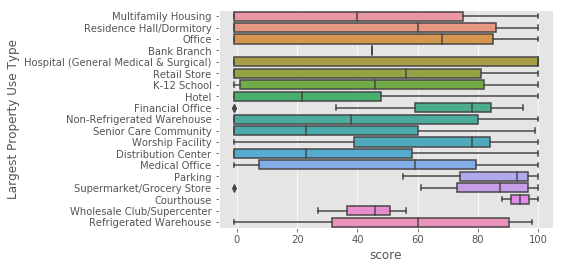

In [6]:
############################################################################
# Verificando os dados categóricos de Propriedade

sns.boxplot(data_full['score'], data_full['Largest Property Use Type'])

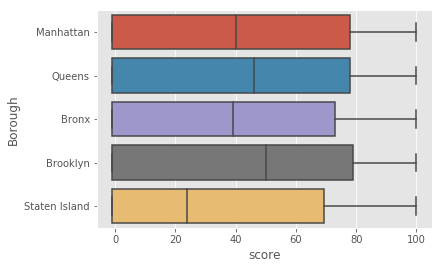

In [7]:
############################################################################
# Verificando os dados categóricos de Borough

sns.boxplot(data_full['score'], data_full['Borough'])

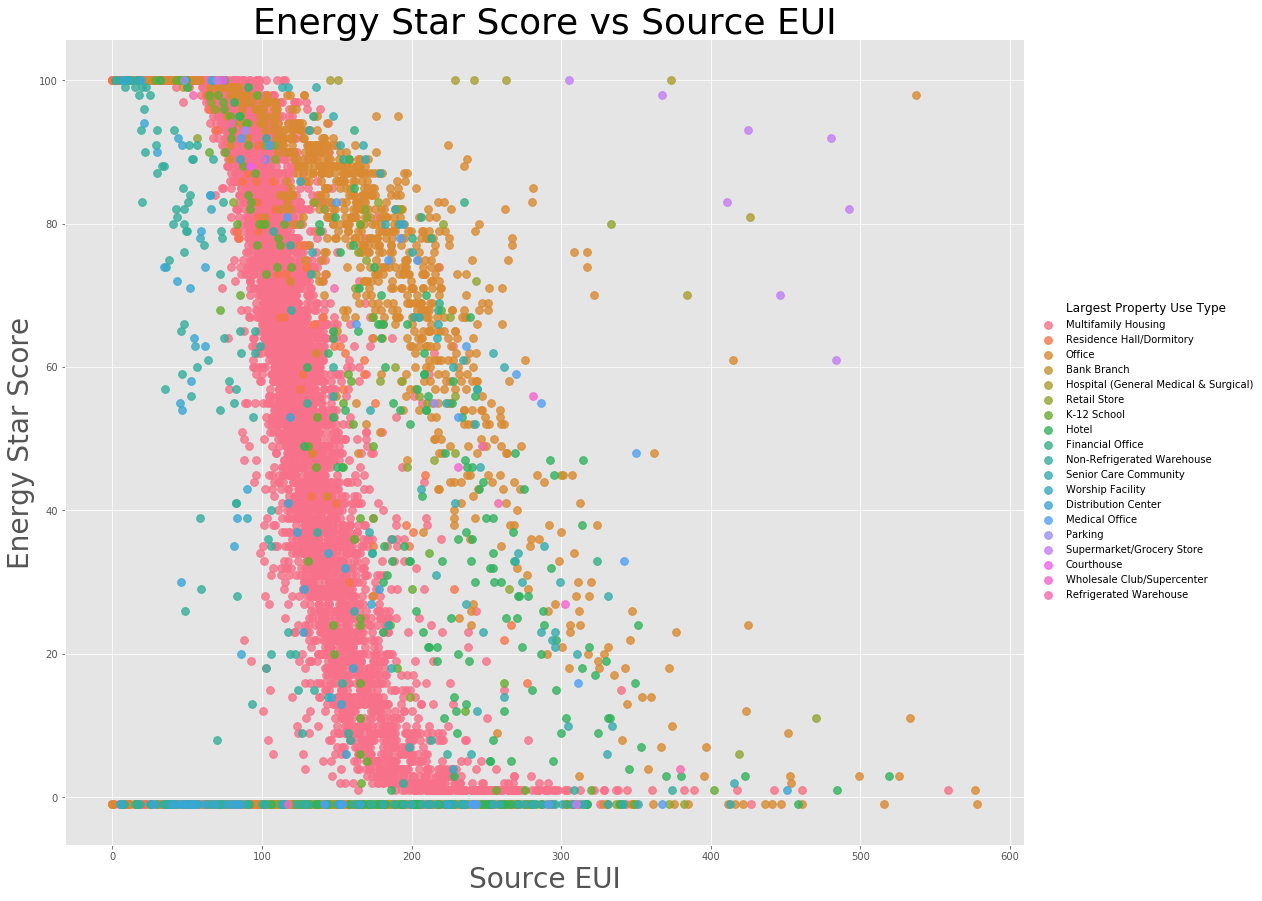

In [8]:
figsize(12, 10)

sns.lmplot('Source EUI (kBtu/ft²)', 'score', 
          hue = 'Largest Property Use Type', data = data_full,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("Source EUI", size = 28)
plt.ylabel('Energy Star Score', size = 28)
plt.title('Energy Star Score vs Source EUI', size = 36);


## Regras de negócio
 
https://portfoliomanager.zendesk.com/hc/en-us/articles/211027418-How-does-EPA-determine-what-variables-to-include-in-the-ENERGY-STAR-score-calculation-   
Colunas de Water não tem validade para score   
Colunas de Fuel não tem validade para score   
Ano de construção nao tem validade para score   
Dados normalizados são mais completos que os puros      
BBL - 10-digit property borough, block and lot identifier, originally entered into the "Property   
   Notes" field in Portfolio Manager and then verified and corrected, as necessary, by the   
   Department of Finance (DOF). The first number represents the borough, where 1 is   
   Manhattan, 2 is the Bronx, 3 is Brooklyn, 4 is Queens, and 5 is Staten Island. The following   
   five numbers represent the tax block. If a property has a tax block that is less than 5 digits,   
   then zeros are added before the block number so there are five digits in total. The last four   
   digits are the tax lot number.   
    
Cálculo do Score:    
We calculate your Actual Source EUI   
We calculate your “Predicted” Source EUI for your Office   
We assume that the predicted Source EUI for your Fitness Center is identical to the predicted Source EUI of your Offic   
The ratio of your actual source EUI to your predicted source EUI is called the efficiency ratio   


Considerações por experimentação:   
Utilizar o bairro retirando do BBL - 10-digit pois o Borough tem mais dados nulos   
Priorizar colunas de Bairro, Energia, SourceEUI, Tamanho máximo da propriedade   
Fazer o cãlculo do rate do score, mesmo não tendo a fórmula completa   
Retirada de colunas com alto grau de correlação - mas considerando as regras de negocio e experimentação   

## Engenharia de Atributos

In [9]:
############################################################################
## Dataframe v2

data_full_v2 = pd.DataFrame()
data_full_v2['Property Id'] = data_full['Property Id']

data_full_v2['Borough'] = data_full['BBL - 10 digits'].str[0:1]
data_full_v2.loc[(data_full_v2['Borough'] == '1'), 'Borough_Named'] = 'Manhattan'
data_full_v2.loc[(data_full_v2['Borough'] == '2'), 'Borough_Named'] = 'Bronx'
data_full_v2.loc[(data_full_v2['Borough'] == '3'), 'Borough_Named'] = 'Brooklyn'
data_full_v2.loc[(data_full_v2['Borough'] == '4'), 'Borough_Named'] = 'Queens'
data_full_v2.loc[(data_full_v2['Borough'] == '5'), 'Borough_Named'] = 'Staten'

data_full_v2['Tax_Block'] = data_full['BBL - 10 digits'].str[1:6]
data_full_v2['DOF_Gross_Floor_Area'] = data_full['DOF Gross Floor Area']
data_full_v2['Largest_Property_Use_Type'] = data_full['Largest Property Use Type']
data_full_v2['Number_Buildings'] = data_full['Number of Buildings - Self-reported']
data_full_v2['Weather_Normalized_Site_Electricity_Intensity'] = data_full['Weather Normalized Site Electricity Intensity (kWh/ft²)']
data_full_v2['Source_EUI'] = data_full['Source EUI (kBtu/ft²)']
data_full_v2['score'] = data_full['score']



############################################################################
## Eliminar uma inconsistência nos dados

data_full_v2['Borough'].replace(u'\u200b', np.nan, inplace=True)



############################################################################
## Ajuste dos valores nulos com a mediana das colunas

data_full_v2.fillna(data_full_v2.median(), inplace=True)



############################################################################
## Conversão de tipos

data_full_v2['Borough'] = data_full_v2['Borough'].astype(int)
data_full_v2['Tax_Block'] = data_full_v2['Tax_Block'].astype(int)
data_full_v2['Weather_Normalized_Site_Electricity_Intensity'] = data_full_v2['Weather_Normalized_Site_Electricity_Intensity'].astype(float)



############################################################################
## Efficience_Ratio é dado pelo SourceEUI dividido pelo SourceEUI estimado
## Existem outras variáveis que não consegui acesso, mas já melhora um pouco a performance

data_mean = data_full_v2.groupby(['Largest_Property_Use_Type'], as_index=False)['Source_EUI'].mean()


data_mean.columns = ['Largest_Property_Use_Type', 'Largest_Property_Use_Type_Source_EUI_Mean']

data_full_v2 = pd.merge(data_full_v2,
        data_mean[['Largest_Property_Use_Type', 'Largest_Property_Use_Type_Source_EUI_Mean']],
                    on='Largest_Property_Use_Type', how='left')

data_full_v2['Efficience_Ratio'] = (data_full_v2['Source_EUI'] / 
                                    data_full_v2['Largest_Property_Use_Type_Source_EUI_Mean']) 



############################################################################
## Ajuste das colunas Borough_Named e Largest_Property_Use_Type para One Hot Encoding

data_dummies = pd.get_dummies(data_full_v2['Largest_Property_Use_Type'])
data_full_v2 = pd.concat([data_full_v2, data_dummies], sort=False, axis=1)


data_dummies = pd.get_dummies(data_full_v2['Borough_Named'])
data_full_v2 = pd.concat([data_full_v2, data_dummies], sort=False, axis=1)



############################################################################
## Drop das colunas desnecessárias

data_full_v2 = data_full_v2.drop('Borough', 1)
data_full_v2 = data_full_v2.drop('Borough_Named', 1)
data_full_v2 = data_full_v2.drop('Source_EUI', 1)
data_full_v2 = data_full_v2.drop('Largest_Property_Use_Type', 1)
data_full_v2 = data_full_v2.drop('Largest_Property_Use_Type_Source_EUI_Mean', 1)


data_full_v2.head(5)

,Property Id,Tax_Block,DOF_Gross_Floor_Area,Number_Buildings,Weather_Normalized_Site_Electricity_Intensity,score,Efficience_Ratio,Bank Branch,Courthouse,Distribution Center,Financial Office,Hospital (General Medical & Surgical),Hotel,K-12 School,Medical Office,Multifamily Housing,Non-Refrigerated Warehouse,Office,Parking,Refrigerated Warehouse,Residence Hall/Dormitory,Retail Store,Senior Care Community,Supermarket/Grocery Store,Wholesale Club/Supercenter,Worship Facility,Bronx,Brooklyn,Manhattan,Queens,Staten
0,2780056,2180,91000.0,2,3.5,72,0.842262,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,4988574,2180,179130.0,1,4.0,67,0.869169,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2806486,1390,91000.0,2,6.1,100,0.942551,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4988686,1390,151666.0,1,6.8,100,0.605809,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4988688,1391,64827.0,1,4.8,100,0.439477,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


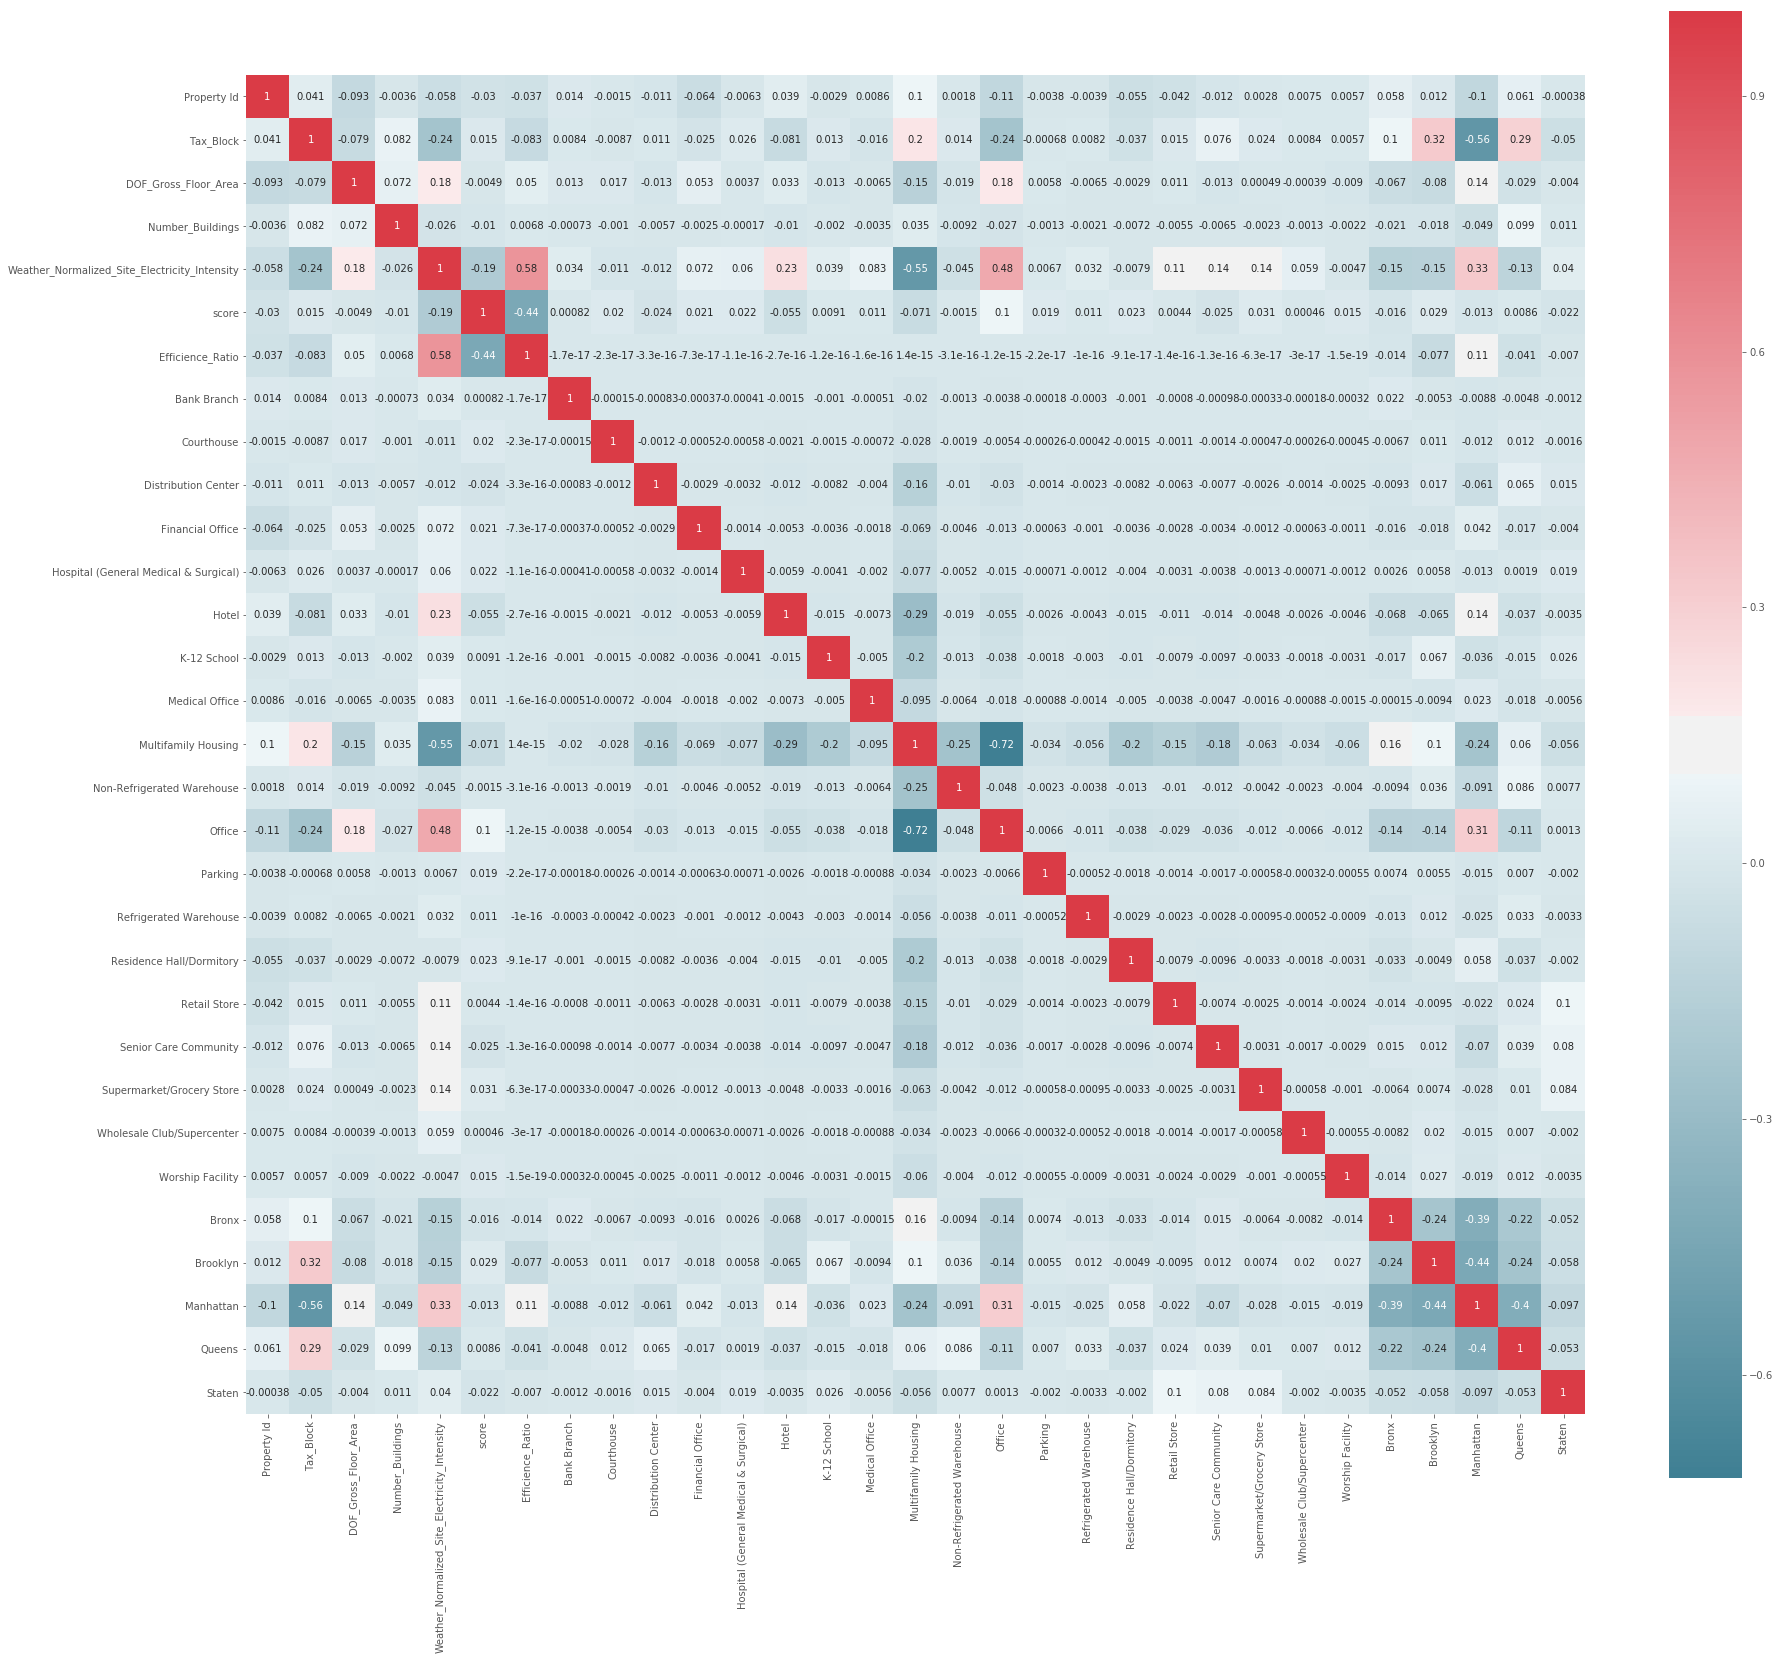

In [10]:
############################################################################
## Correlação após ajustes das colunas

corr = data_full_v2.corr()
_ , ax = plt.subplots( figsize =( 30 , 30 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = {'fontsize' : 10 })

## Split

In [11]:
############################################################################
## Separação do train, test e target

features_train = data_full_v2[data_full_v2['score'] != -1]
features_test = data_full_v2[data_full_v2['score'] == -1]

Property_Id_test = features_test[['Property Id']]
targets_train = pd.DataFrame(features_train['score'])


############################################################################
## Drop das colunas desnecessárias

features_train = features_train.drop('Property Id', 1)
features_test = features_test.drop('Property Id', 1)
features_test = features_test.drop('score', 1)
features_train = features_train.drop('score', 1)


X = features_train.values
y = np.array(targets_train).reshape((-1, ))

X_test = features_test.values

## Hiperparam tuning

In [12]:
############################################################################
## Tuning parâmetros
## Obs: Se demorar para rodar pular para próximo passo

loss = ['ls', 'lad', 'huber']
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 4, 6, 10]
max_features = ['auto', 'sqrt', 'log2', None]


hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features
                      }

model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv = 8, 
                               n_iter = 25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, 
                               verbose = 1, 
                               return_train_score = True,
                               random_state=42)

random_cv.fit(X, y)

print (random_cv.best_score_)
print (random_cv.best_params_)

Fitting 8 folds for each of 25 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.2min finished


-8.7783809328611
{'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': None, 'max_depth': 5, 'loss': 'lad'}


## Modelo Final

In [13]:
############################################################################
## Modelo Final

model = GradientBoostingRegressor(
    n_estimators = 500
    ,min_samples_split = 6
    ,min_samples_leaf = 6
    ,max_features = None
    ,max_depth = 5
    ,loss = 'lad'
    ,random_state=42)

model.fit(X, y)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
############################################################################
## Resultado

pred = np.round(model.predict(X_test)).astype(int)
pred[pred > 100] = 100
pred[pred < 1] = 1


submission = pd.DataFrame({'Property Id': Property_Id_test['Property Id'], 'score': pred })
submission.to_csv('submission.csv',index=False)

## Fim !!